In [ ]:
# Global/WindowsApps (3.9.13)
!pip3 install --user fredapi
!pip3 install --user matplotlib
!pip3 install --user numpy
!pip3 install --user scipy
!pip3 install --user pandas
!pip3 install --user seaborn
!pip3 install --user sklearn
!pip3 install --user pandas_datareader

In [82]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from dateutil import relativedelta
import yfinance as yf
from pandas_datareader import data as pdr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque


from FeatureLoader import FeatureLoader
!source ~/.bash_profile

In [83]:
# Cal Momentum of cooper/ oil
key = os.environ.get('FRED_KEY')
fred_loader = FeatureLoader(key)

In [92]:
yf_tickers = {'S&P500':'SPY'}
fred_tickers = {'PPI_COPPER':'WPUSI019011','PPI_OIL':'PCU333132333132'}
sdate = '2004-01-01'
edate = '2022-07-01'


def get_yf_rawdata(tickers:list):
    yf.pdr_override()
    df_price = pdr.get_data_yahoo(tickers)
    df_price.isnull().sum()
    df_price.dropna(axis=0,inplace=True)
    return df_price


In [177]:
fred_cols = list(fred_tickers.keys())

yf_cols = list(yf_tickers.keys())
cols = fred_cols + yf_cols
trading_df = pd.DataFrame([], columns=cols)

for k in yf_cols:
    df_yf = get_yf_rawdata(yf_tickers[k])
    series = df_yf.loc[ (df_yf.index>=sdate) & (df_yf.index<=edate)]['Close']
    #series = fred_loader.normalize(series)
    trading_df[k] = series
    
for k in fred_cols:   
    series = fred_loader.load_series(ticker = fred_tickers[k],start=sdate, end=edate)
    #series = fred_loader.normalize(series)
    series = fred_loader.monthly_to_daily(series)
    trading_df[k] = series

print(trading_df.tail())

[*********************100%***********************]  1 of 1 completed
            PPI_COPPER  PPI_OIL      S&P500
Date                                       
2022-06-27     542.649  289.695  388.589996
2022-06-28     542.649  289.695  380.649994
2022-06-29     542.649  289.695  380.339996
2022-06-30     542.649  289.695  377.250000
2022-07-01     542.649  289.695  381.239990


,PPI_COPPER,PPI_OIL,S&P500
PPI_COPPER,1.000000,0.574434,0.374626
PPI_OIL,0.574434,1.000000,0.610986
S&P500,0.374626,0.610986,1.000000


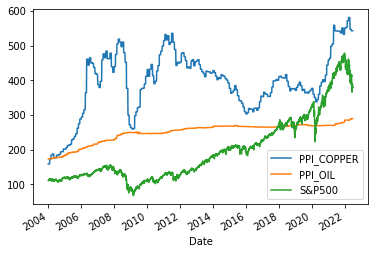

In [178]:
trading_df.plot()
trading_df.corr()

In [229]:
__INTERVAL__ = 30*6
__WINDOW__ = 60
ppi_copper = trading_df['PPI_COPPER'] - trading_df['PPI_COPPER'].shift(__INTERVAL__)
ppi_oil = trading_df['PPI_OIL'] - trading_df['PPI_OIL'].shift(__INTERVAL__)

,SCORE,SPY
SCORE,1.00000,0.54166
SPY,0.54166,1.00000


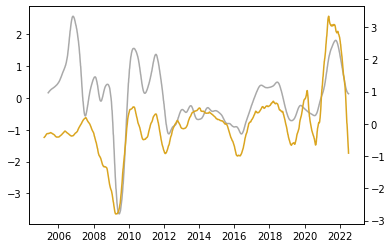

In [232]:
ppi_copper= ppi_copper.rolling(__WINDOW__).mean()
ppi_oil= ppi_oil.rolling(__WINDOW__).mean()

a=3
b=1
score = a*ppi_copper + b*ppi_oil
spy = trading_df['S&P500'] - trading_df['S&P500'].shift(__INTERVAL__)
spy = spy.rolling(__WINDOW__*2).mean()
#a.corr()

ret = pd.DataFrame([])
ret['SCORE'] = fred_loader.standardize(score)
ret['SPY'] = fred_loader.standardize(spy)

fred_loader.dual_plot(ret['SCORE'],ret['SPY'])


#ret.plot()
ret.corr()

In [ ]:
# trading
